In [228]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

Analysing N_trees Trade-offs

In [229]:
data = pd.read_csv("training_data/training_data.csv")
cam = pd.read_csv("camera_id_lat_long.csv")

In [230]:
data = data.drop(
            ["Time", "Date", "Average_Speed",
                "Vehicle_Count", "Density", "Incident"],
            axis=1,
        )
for col in data.dtypes[data.dtypes == "object"].index:
    for_dummy = data.pop(col)
    data = pd.concat(
        [data, pd.get_dummies(for_dummy, prefix=col)], axis=1)

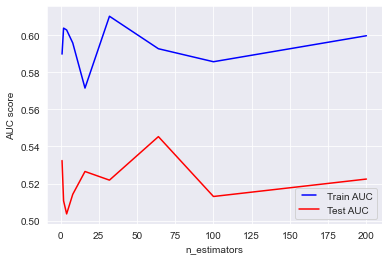

In [231]:
labels = data.pop("Jam")
seed = 3101
x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.25, random_state = seed
)
model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train AUC")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [232]:
index = test_results.index(max(test_results))
best_n = n_estimators[index]
model = RandomForestClassifier(n_estimators=best_n)
model.fit(data, labels)

RandomForestClassifier(n_estimators=64)

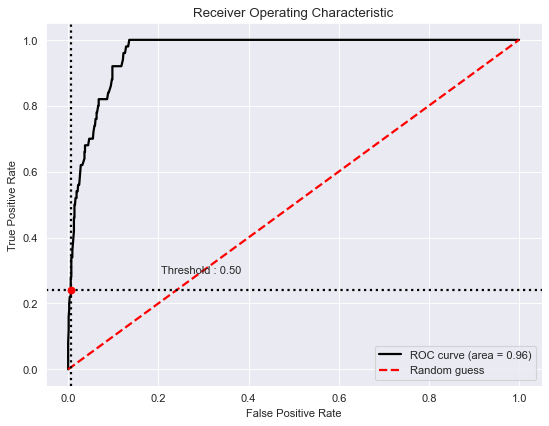

In [233]:
y_pred = model.predict_proba(x_test)[:,1]
from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])
plt.figure(figsize=(8, 6), dpi=80)
bc.plot_roc_curve()
plt.show()

AUC of exported RF Model

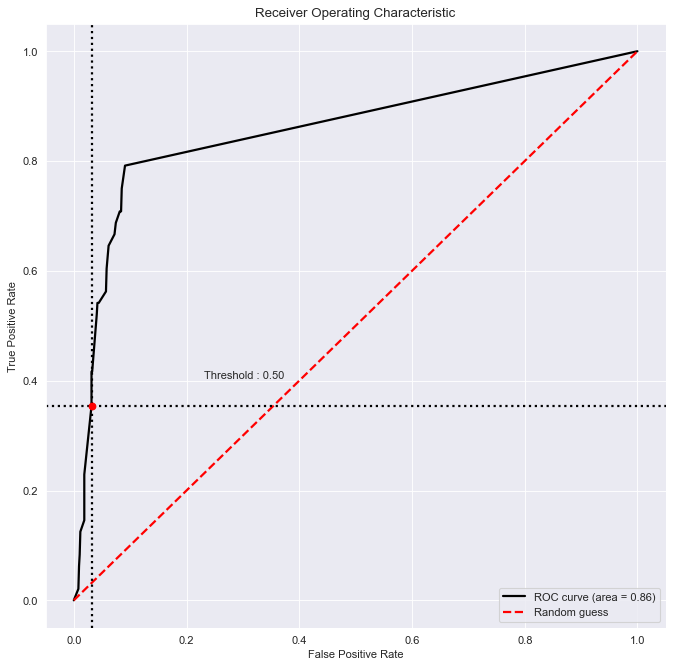

In [312]:
import pickle
data = pd.read_csv("training_data/training_data.csv")
data = data.drop(
            ["Time", "Date", "Average_Speed",
                "Vehicle_Count", "Density", "Incident"],
            axis=1,
        )
for col in data.dtypes[data.dtypes == "object"].index:
    for_dummy = data.pop(col)
    data = pd.concat(
        [data, pd.get_dummies(for_dummy, prefix=col)], axis=1)
labels = data.pop("Jam")
x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.25, random_state = 50
)
model2 = pickle.load(open("model.pkl", "rb"))
y_pred = model2.model.predict_proba(x_test)[:,1]
from plot_metric.functions import BinaryClassification
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])
plt.figure(figsize=(10, 10), dpi=80)
bc.plot_roc_curve()
# plt.savefig("AUC_Final.png")
plt.show()

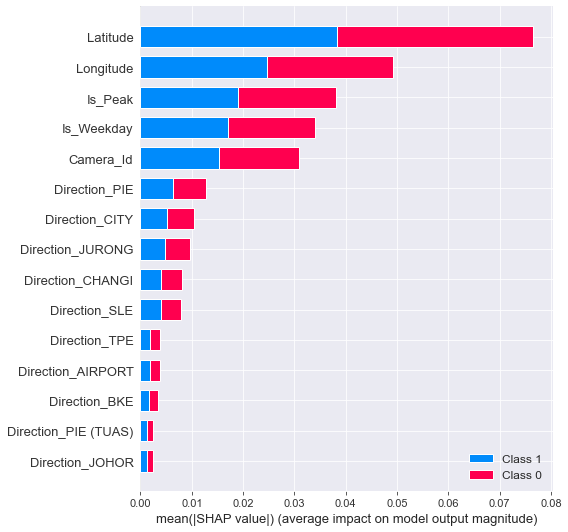

In [311]:
import matplotlib.pyplot as plt
import shap
shap_values = shap.TreeExplainer(model2.model).shap_values(x_test)
f = plt.figure()
shap.summary_plot(shap_values, x_test, max_display = 15)
f.savefig("shap.png", bbox_inches='tight', dpi=600)

In [314]:
rf_shap_values = shap.KernelExplainer(model2.model.predict,x_test)

Using 906 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [316]:
shap.summary_plot(rf_shap_values, x_test)

AttributeError: 'Kernel' object has no attribute 'shape'

Using 2716 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 100/100 [1:03:33<00:00, 38.14s/it]


AssertionError: Feature and SHAP matrices must have the same number of rows!

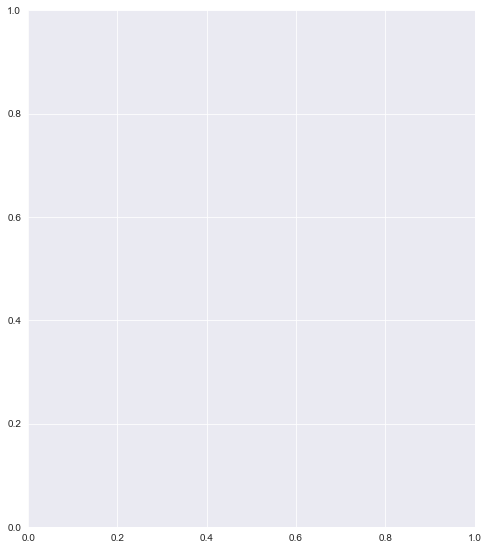

In [329]:
f = plt.figure()
shap.initjs()
rf_explainer = shap.KernelExplainer(model2.model.predict,x_train)
rf_shap_values = rf_explainer.shap_values(shap.sample(x_test, 100))
shap.summary_plot(rf_shap_values, x_test)
f.savefig("summary_plot1.png", bbox_inches='tight', dpi=600)